In [1]:
#import tensorflow as tf
#print(tf.__version__)
#2.13.0

In [2]:
#!pip uninstall tensorflow keras -y
#!pip install tensorflow==2.15.0
#!pip install TA-Lib


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.base import BaseEstimator
import time
import yfinance as yf


import time
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization

#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    
    print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original

In [5]:
# =============================================================================
# Function 1: Create Multi-Feature Time-Series Data (Target = LogReturn)
# =============================================================================
def create_time_series_data(data, look_back=10):
    """
    Converts a 2D NumPy array of shape (num_samples, num_features)
    into time-series arrays for LSTM.
    
    Here the target (y) is set to the value of the first column (LogReturn)
    at time (i + look_back).
    
    Returns:
      X: Array of shape (num_samples - look_back, look_back, num_features)
      y: Array of shape (num_samples - look_back,) – the target log returns.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, :])
        # Target is now the next day's LogReturn (assumed to be column 0)
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

# =============================================================================
# Function 2: Split Data & Compute Features (LogReturn and SMAs)
# =============================================================================
def split_data(data, sma_windows, look_back, train_start, train_end, test_start, test_end):
    """
    1. Computes log returns.
    2. Computes SMAs for each window in sma_windows.
    3. Drops NaN values.
    4. Splits data into train and test sets based on date ranges.
    5. Creates time-series arrays (X, y) where y is the next day's log return.
    
    Returns:
      X_train, X_test, y_train, y_test, feature_cols
    """
    data = data.copy()
    # Compute log returns
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    # Compute SMAs for each window size
    for w in sma_windows:
        data[f'SMA_{w}'] = data['Close'].rolling(window=w).mean()
        
    # Compute RSI (14-day period)
    data['RSI_14'] = ta.rsi(data['Close'], length=14)
    data.dropna(inplace=True)
    
    
    #train_data = data.loc[train_start:train_end].copy()
    #test_data  = data.loc[test_start:test_end].copy()
    
    train_size = int(len(data) * 0.70)
    train_data, test_data = data[:train_size], data[train_size:]
    #train_data, test_data = data.loc[:train_size], data.loc[train_size:]
    
    print(train_data.shape)
    print(test_data.shape)
    
    # Feature order: first column is LogReturn (target), then SMAs, then Close.
    #feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['Close']
    # Feature order: LogReturn, SMAs, RSI, Close
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['RSI_14'] + ['Close']
    
    
    X_train, y_train = create_time_series_data(train_data[feature_cols].values, look_back)
    X_test,  y_test  = create_time_series_data(test_data[feature_cols].values, look_back)
    
    return X_train, X_test, y_train, y_test, feature_cols

# =============================================================================

In [6]:
# =============================================================================
# Function 3: Scale the Data
# =============================================================================
def scale_data(X_train, X_test, y_train, y_test):
    """
    Scales the features and target.
    The feature scaler is applied to the flattened feature set and then reshaped back.
    """
    feature_scaler = MinMaxScaler()
    target_scaler  = MinMaxScaler()
    
    n_train, lb, nf = X_train.shape
    X_train_2d = X_train.reshape(n_train * lb, nf)
    n_test, lb_test, nf_test = X_test.shape
    X_test_2d = X_test.reshape(n_test * lb_test, nf_test)
    
    X_train_scaled_2d = feature_scaler.fit_transform(X_train_2d)
    X_test_scaled_2d  = feature_scaler.transform(X_test_2d)
    
    X_train_scaled = X_train_scaled_2d.reshape(n_train, lb, nf)
    X_test_scaled  = X_test_scaled_2d.reshape(n_test, lb_test, nf_test)
    
    # Scale target (log returns)
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled  = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# =============================================================================
# Function 4: Build LSTM Model
# =============================================================================
def build_lstm_model(units, dropout, learning_rate, look_back, num_features):
    
    #model = Sequential()
    #model.add(LSTM(units, input_shape=(look_back, num_features), activation='relu'))
    #model.add(Dropout(dropout))
    #model.add(Dense(1))
    #model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation='relu'), 
                            input_shape=(look_back, num_features)))
    # Batch Normalization (Stabilizes training)
    #model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    #model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=0.9), loss='mean_squared_error')

    #model = Sequential()
    # First LSTM layer returns the full sequence
    #model.add(LSTM(units, return_sequences=True, 
    #               input_shape=(look_back, num_features), 
    #               activation='relu'))
    # Second LSTM layer (receives the full sequence from the previous layer)
    #model.add(LSTM(units, activation='relu'))
    #model.add(Dropout(dropout))
    #model.add(Dense(1))
    #model.compile(optimizer=Adam(learning_rate=learning_rate), 
    #              loss='mean_squared_error')
    
    return model

# =============================================================================
# Function 5: LSTMRegressor (Sklearn Wrapper)
# =============================================================================
class LSTMRegressor(BaseEstimator):
    def __init__(self, units=64, dropout=0.2, learning_rate=0.01, epochs=10, batch_size=32, look_back=10, num_features=5):
        self.units = units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.look_back = look_back
        self.num_features = num_features
        self.model_ = None
        
    def fit(self, X, y):
        self.model_ = build_lstm_model(self.units, self.dropout, self.learning_rate, self.look_back, self.num_features)
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        return self.model_.predict(X, verbose=0)

# =============================================================================
# Function 6: Bayesian Hyperparameter Optimization for LSTMRegressor
# =============================================================================
def model_training(X_train_scaled, y_train_scaled, look_back, num_features):
    """param_space = {
        'units': Categorical([64, 128]),
        'dropout': Categorical([0.2, 0.3, 0.4]),
        'learning_rate': Categorical([0.001, 0.01, 0.05]),
    }"""
    param_space = {
    'units': Integer(32, 128),
    'dropout': Real(0.3, 0.7),
    'learning_rate': Real(0.001, 0.05, prior='log-uniform'),
    }
    
    estimator = LSTMRegressor(look_back=look_back, num_features=num_features)
    bayes_search = BayesSearchCV(estimator, param_space, n_iter=30, cv=3, scoring='neg_mean_squared_error', random_state=42)
    
    y_train_scaled_2d = y_train_scaled.reshape(-1, 1)
    #start_time = time.time()
    bayes_search.fit(X_train_scaled, y_train_scaled_2d)
    #end_time = time.time()
    #print(f"Bayesian Optimization Time: {end_time - start_time:.2f} seconds")
    print("Best Model Parameters:", bayes_search.best_params_)
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    return best_model, best_params

# =============================================================================
# Function 7: Train Final Model on Full Dataset
# =============================================================================
def train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features):
    # Use all data from 2000-01-01 to 2023-12-31
    X_full, _, y_full, _, _ = split_data(data, sma_windows, look_back, "2000-01-01", "2023-12-31", None, None)
    
    n_full, lb, nf = X_full.shape
    X_full_2d = X_full.reshape(n_full * lb, nf)
    X_full_scaled_2d = feature_scaler.transform(X_full_2d)
    X_full_scaled = X_full_scaled_2d.reshape(n_full, lb, nf)
    
    y_full_scaled = target_scaler.transform(y_full.reshape(-1, 1))
    
    final_model = LSTMRegressor(
        units=best_params['units'],
        dropout=best_params['dropout'],
        learning_rate=best_params['learning_rate'],
        epochs=10,
        batch_size=32,
        look_back=look_back,
        num_features=num_features
    )
    final_model.fit(X_full_scaled, y_full_scaled)
    return final_model

# =============================================================================

In [7]:
# =============================================================================
def forecast_future_multi_step(
    data,
    model,
    feature_scaler,
    target_scaler,
    sma_windows,
    look_back,
    start_date="2024-01-01",
    end_date="2024-12-31"
):
    """
    Recursively forecasts future log returns and computes forecasted 'Close' prices
    from those log returns for every business day between start_date and end_date.

    Parameters:
      data: DataFrame with at least a 'Close' column.
      model: Trained LSTM model (expects input shape: (None, look_back, num_features)).
      feature_scaler: Fitted scaler for the multi-feature inputs.
      target_scaler: Fitted scaler for the target (LogReturn).
      sma_windows: List of integers (e.g., [5, 10, 15]) for computing SMAs.
      look_back: Number of past rows used as input.
      start_date: Forecast start date (e.g., "2024-01-01").
      end_date: Forecast end date (e.g., "2024-12-31").

    Returns:
      pred_df: DataFrame with forecasted 'LogReturn' and computed 'Close' for each future date.
      forecast_df: DataFrame with historical data and appended forecast rows.
    """
    import sys
    data = data.copy()
    
    # Compute LogReturn if not present
    if 'LogReturn' not in data.columns:
        data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Compute SMAs if not present
    for w in sma_windows:
        sma_col = f'SMA_{w}'
        if sma_col not in data.columns:
            data[sma_col] = data['Close'].rolling(window=w).mean()
    
    # Compute RSI if not present
    if 'RSI_14' not in data.columns:
        data['RSI_14'] = ta.rsi(data['Close'], length=14)

    data.dropna(inplace=True)  # Ensure we start with no NaNs
    
    # Ensure index is DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    # Initialize forecast_df with all data before start_date.
    forecast_df = data[data.index < start_date].copy()
    if forecast_df.empty:
        forecast_df = data.copy()

    # Define feature order (same as training)
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['RSI_14', 'Close']
    
    # Generate future business dates
    future_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    predictions = []
    
    #print("\n=== Recursive Forecasting Process ===\n", flush=True)
    
    for i, date in enumerate(future_dates):
        last_window = forecast_df.iloc[-look_back:].copy()
        if len(last_window) < look_back:
            print("Not enough rows for a full look_back window. Breaking loop.", flush=True)
            break
        
        try:
            last_window_2d = last_window[feature_cols].values
        except KeyError as e:
            print(f"Error: {e}. Feature columns available: {list(last_window.columns)}", flush=True)
            break
        
        # Scale and reshape input for LSTM
        scaled_2d = feature_scaler.transform(last_window_2d)
        X_3d = scaled_2d.reshape(1, look_back, len(feature_cols))
        
        # Predict the scaled log return.
        scaled_pred_log_return = model.predict(X_3d)[0][0]
        
        # Invert scaling to obtain predicted log return.
        pred_log_return = target_scaler.inverse_transform([[scaled_pred_log_return]])[0][0]
        
        # Check for NaN predictions and replace with 0
        if np.isnan(pred_log_return):
            print(f"Warning: NaN detected in predicted log return at step {i+1}. Replacing with 0.")
            pred_log_return = 0.0
        
        predictions.append((date, pred_log_return))
        
        # Compute new predicted 'Close'
        prev_close = forecast_df['Close'].iloc[-1]
        pred_close = prev_close * np.exp(pred_log_return)
        
        #print(f"Step {i+1}: Date={date}")
        #print(f"  - Predicted LogReturn: {pred_log_return}")
        #print(f"  - Previous Close: {prev_close}, Predicted Close: {pred_close}")

        # Create a new row for this forecasted date
        new_row = {'LogReturn': pred_log_return, 'Close': pred_close}
        
        # Recompute SMAs dynamically for the new forecasted row
        num_rows_needed = max(sma_windows) - 1
        temp_df = pd.concat([
            forecast_df.iloc[-num_rows_needed:],
            pd.DataFrame([new_row], index=[date])
        ])
        for w in sma_windows:
            temp_df[f'SMA_{w}'] = temp_df['Close'].rolling(window=w).mean()

        # Compute RSI dynamically for new predicted Close price
        temp_df['RSI_14'] = ta.rsi(temp_df['Close'], length=14)

        # Fill any NaN values for SMA and RSI
        for w in sma_windows:
            temp_df[f'SMA_{w}'].fillna(temp_df['Close'], inplace=True)  # Replace NaN SMA with Close price
        temp_df['RSI_14'].fillna(50, inplace=True)  # Replace NaN RSI with neutral value 50

        # Get updated row with SMA and RSI
        updated_new_row = temp_df.iloc[-1].to_dict()
        
        # Append the new row into forecast_df.
        forecast_df.loc[date, 'Close'] = updated_new_row['Close']
        forecast_df.loc[date, 'LogReturn'] = updated_new_row['LogReturn']
        forecast_df.loc[date, 'RSI_14'] = updated_new_row['RSI_14']
        for w in sma_windows:
            forecast_df.loc[date, f'SMA_{w}'] = updated_new_row[f'SMA_{w}']
        
        #print(f"  - Updated SMA Values: {[updated_new_row[f'SMA_{w}'] for w in sma_windows]}")
        #print(f"  - Updated RSI Value: {updated_new_row['RSI_14']}\n", flush=True)
    
    #print("\n=== Forecasting Complete ===", flush=True)
    
    pred_df = pd.DataFrame(predictions, columns=['Date', 'Forecasted_Log_Return']).set_index('Date')
    
    return pred_df, forecast_df

In [8]:
# =============================================================================
# Function 9: Main Function to Run the Pipeline (Now for LogReturn Forecasting)
# =============================================================================
def main(data):
    look_back = 10
    sma_windows = [5, 10, 15]
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end   = "2015-01-01", "2024-01-01"
    
    # 9.1) Split data and compute features.
    X_train, X_test, y_train, y_test, feature_cols = split_data(data, sma_windows, look_back,
                                                                 train_start, train_end,
                                                                 test_start, test_end)
    # 9.2) Scale the data.
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)
    _, _, num_features = X_train_scaled.shape
    
    start_time = time.time()  
    # 9.3) Bayesian hyperparameter tuning.
    best_model, best_params = model_training(X_train_scaled, y_train_scaled, look_back, num_features)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
     # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    
    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse
                },
                "time":computaton_time
                
        }
    
    # 9.4) Train the final model on the full dataset.
    final_model = train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features)
    
    # 9.5) Forecast future log returns (and compute forecasted closes).
    pred_df, forecast_df = forecast_future_multi_step(data, final_model, feature_scaler, target_scaler,
                                                       sma_windows, look_back,
                                                       start_date="2024-01-01", end_date="2024-12-31")
    print("\n=== Future LogReturn Predictions ===")
    print(pred_df)
    
    return final_model, pred_df, forecast_df, model_metrics

# =============================================================================

In [9]:
# Download historical data.
"""data = yf.download("SOXX", start="2000-01-01", end="2023-12-31")
data.index = pd.to_datetime(data.index)

# Run the full pipeline.
final_model, future_preds, full_forecast_df = main(data)
"""

'data = yf.download("SOXX", start="2000-01-01", end="2023-12-31")\ndata.index = pd.to_datetime(data.index)\n\n# Run the full pipeline.\nfinal_model, future_preds, full_forecast_df = main(data)\n'

In [10]:
#monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2024)
#results2={}    
# Step 4: Store results in the dictionary.
#results2['SOXX'] = {
#    "monthly_forecast_results": monthly_forecasts,
#    "weekly_forecast_results": weekly_forecasts
#}

In [11]:
#weekly_forecasts

In [12]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [13]:
# =============================================================================
# Workflow Function for Multiple Tickers
# =============================================================================
def run_workflow(tickers):
    """
    Runs the full forecasting workflow for multiple stock tickers.
    
    For each ticker:
      1. Downloads historical data.
      2. Runs the full pipeline (via main(data)) to get forecasts.
      3. Groups forecasted returns/prices month-wise and week-wise for 2024.
      4. Stores the grouped forecasts in a results dictionary.
      
    Parameters:
      tickers: List of ticker symbols (strings).
      
    Returns:
      results: A dictionary keyed by ticker with grouped forecast results.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download historical data
        data = yf.download(ticker, start="2000-01-01", end="2023-12-31")
        data.index = pd.to_datetime(data.index)
        
        # Step 2: Run the full pipeline.  
        # Assume that main() returns (final_model, future_preds, full_forecast_df)
        final_model, future_preds, full_forecast_df, model_metrics = main(data)
               

        # Step 3: Group forecasted returns/prices month-wise and week-wise for 2024.
        # (Here, future_preds is assumed to be a DataFrame with a DateTime index.
        #  For example, it might have a column 'Forecasted_Close' or 'Forecasted_LogReturn'.)
        monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2024)
        
        # Step 4: Store results in the dictionary.
        results[ticker] = {
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
        
    return results
# List of tickers to process.
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']
#tickers = ['PSI', 'IGM']

# Execute the workflow for multiple tickers.
results = run_workflow(tickers)

Processing SMH...


[*********************100%%**********************]  1 of 1 completed


(4141, 11)
(1776, 11)
Best Model Parameters: OrderedDict([('dropout', 0.5229564454171507), ('learning_rate', 0.00816683846254128), ('units', 87)])
Computation Time: 373.69 seconds
Scaled RMSE: 0.088579317405218, Scaled MAE: 0.06177434389956076
Original RMSE: 0.02241682583057545, Original MAE: 0.015633273640351476
Scaled RMSE: 0.19618422566593247, Scaled MAE: 0.15044994676104104
Original RMSE: 0.04964847099914712, Original MAE: 0.03807446680906223
Train RMSE: 0.0224, Train MAE: 0.0156
Test RMSE: 0.0496, Test MAE: 0.0381
(4141, 11)
(1776, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.004761
2024-01-02              -0.004748
2024-01-03              -0.004732
2024-01-04              -0.004723
2024-01-05              -0.004703
2024-01-08              -0.004696
2024-01-09              -0.004684
2024-01-10              -0.004676
2024-01-11              -0.004667
2024-01-12              -0.004653
2024-01

[*********************100%%**********************]  1 of 1 completed


(3946, 11)
(1692, 11)
Best Model Parameters: OrderedDict([('dropout', 0.30145212290189727), ('learning_rate', 0.0245170759286383), ('units', 103)])
Computation Time: 316.49 seconds
Scaled RMSE: 0.08963279345679205, Scaled MAE: 0.06411851960331669
Original RMSE: 0.02033466121493252, Original MAE: 0.014546332022803218
Scaled RMSE: 0.09250114697073299, Scaled MAE: 0.06690732537880037
Original RMSE: 0.020985393998620892, Original MAE: 0.015179018103863701
Train RMSE: 0.0203, Train MAE: 0.0145
Test RMSE: 0.0210, Test MAE: 0.0152
(3946, 11)
(1692, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.000521
2024-01-02              -0.000513
2024-01-03              -0.000515
2024-01-04              -0.000479
2024-01-05              -0.000509
2024-01-08              -0.000498
2024-01-09              -0.000504
2024-01-10              -0.000497
2024-01-11              -0.000491
2024-01-12              -0.000486
20

[*********************100%%**********************]  1 of 1 completed


(3253, 11)
(1395, 11)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.039442188758708155), ('units', 48)])
Computation Time: 311.11 seconds
Scaled RMSE: 0.09864057072717654, Scaled MAE: 0.07354530290907033
Original RMSE: 0.01722487115587253, Original MAE: 0.012842670692918551
Scaled RMSE: 0.13145455724796348, Scaled MAE: 0.09670519978356096
Original RMSE: 0.022954934206912008, Original MAE: 0.016886911681565683
Train RMSE: 0.0172, Train MAE: 0.0128
Test RMSE: 0.0230, Test MAE: 0.0169
(3253, 11)
(1395, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.000312
2024-01-02              -0.000315
2024-01-03              -0.000315
2024-01-04              -0.000309
2024-01-05              -0.000313
2024-01-08              -0.000313
2024-01-09              -0.000315
2024-01-10              -0.000315
2024-01-11              -0.000314
2024-01-12              -0.000313
20

[*********************100%%**********************]  1 of 1 completed


(3144, 11)
(1348, 11)
Best Model Parameters: OrderedDict([('dropout', 0.5543627234822357), ('learning_rate', 0.007554233791273705), ('units', 61)])
Computation Time: 306.31 seconds
Scaled RMSE: 0.09512658828125968, Scaled MAE: 0.06985373845854993
Original RMSE: 0.01787753044548119, Original MAE: 0.013127899977228798
Scaled RMSE: 0.1242463404606983, Scaled MAE: 0.09268554334686631
Original RMSE: 0.02335012508138377, Original MAE: 0.01741877484945173
Train RMSE: 0.0179, Train MAE: 0.0131
Test RMSE: 0.0234, Test MAE: 0.0174
(3144, 11)
(1348, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.000188
2024-01-02              -0.000274
2024-01-03              -0.000310
2024-01-04              -0.000399
2024-01-05              -0.000207
2024-01-08              -0.000423
2024-01-09              -0.000483
2024-01-10              -0.000607
2024-01-11              -0.000634
2024-01-12              -0.000587
2024-

[*********************100%%**********************]  1 of 1 completed


(4148, 11)
(1779, 11)
Best Model Parameters: OrderedDict([('dropout', 0.6186890645783081), ('learning_rate', 0.019206715010406685), ('units', 64)])
Computation Time: 408.45 seconds
Scaled RMSE: 0.06984996851778365, Scaled MAE: 0.047012302357449895
Original RMSE: 0.017547563030435677, Original MAE: 0.011810332293029432
Scaled RMSE: 0.0651022016379578, Scaled MAE: 0.044815233425844175
Original RMSE: 0.016354838962670596, Original MAE: 0.011258389230044154
Train RMSE: 0.0175, Train MAE: 0.0118
Test RMSE: 0.0164, Test MAE: 0.0113
(4148, 11)
(1779, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.001972
2024-01-02              -0.001958
2024-01-03              -0.001924
2024-01-04              -0.002037
2024-01-05              -0.002217
2024-01-08              -0.002493
2024-01-09              -0.002908
2024-01-10              -0.003401
2024-01-11              -0.003717
2024-01-12              -0.004396


[*********************100%%**********************]  1 of 1 completed


(4216, 11)
(1807, 11)
Best Model Parameters: OrderedDict([('dropout', 0.3077969643425964), ('learning_rate', 0.013690554191829643), ('units', 61)])
Computation Time: 401.47 seconds
Scaled RMSE: 0.0687907297011525, Scaled MAE: 0.04642765334510182
Original RMSE: 0.016496723615121427, Original MAE: 0.011133828186999015
Scaled RMSE: 0.06638157939965529, Scaled MAE: 0.04558625378652952
Original RMSE: 0.01591898462187831, Original MAE: 0.010932051926171983
Train RMSE: 0.0165, Train MAE: 0.0111
Test RMSE: 0.0159, Test MAE: 0.0109
(4216, 11)
(1807, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01          -7.080812e-04
2024-01-02          -6.801726e-04
2024-01-03          -6.362191e-04
2024-01-04          -6.117696e-04
2024-01-05          -5.017573e-04
2024-01-08          -4.513931e-04
2024-01-09          -3.936318e-04
2024-01-10          -3.310035e-04
2024-01-11          -4.496564e-04
2024-01-12          -3.062466e-04
202

[*********************100%%**********************]  1 of 1 completed


(3500, 11)
(1500, 11)
Best Model Parameters: OrderedDict([('dropout', 0.31636832690159983), ('learning_rate', 0.012981329511042656), ('units', 32)])
Computation Time: 354.75 seconds
Scaled RMSE: 0.06809869429699135, Scaled MAE: 0.047868765949532203
Original RMSE: 0.012758234582531745, Original MAE: 0.00896817408123548
Scaled RMSE: 0.09095070554025979, Scaled MAE: 0.06417092473585767
Original RMSE: 0.017039540166437432, Original MAE: 0.012022370173708144
Train RMSE: 0.0128, Train MAE: 0.0090
Test RMSE: 0.0170, Test MAE: 0.0120
(3500, 11)
(1500, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.002110
2024-01-02              -0.002178
2024-01-03              -0.002291
2024-01-04              -0.002636
2024-01-05              -0.002345
2024-01-08              -0.002405
2024-01-09              -0.002383
2024-01-10              -0.002478
2024-01-11              -0.002641
2024-01-12              -0.002956


[*********************100%%**********************]  1 of 1 completed


(4216, 11)
(1807, 11)
Best Model Parameters: OrderedDict([('dropout', 0.6198213766428693), ('learning_rate', 0.005548792044368401), ('units', 83)])
Computation Time: 423.96 seconds
Scaled RMSE: 0.07203061534316915, Scaled MAE: 0.047732073897477245
Original RMSE: 0.017969978092624444, Original MAE: 0.011908052126694765
Scaled RMSE: 0.05932004593591655, Scaled MAE: 0.04084943343517878
Original RMSE: 0.01479898402363066, Original MAE: 0.010190991985750667
Train RMSE: 0.0180, Train MAE: 0.0119
Test RMSE: 0.0148, Test MAE: 0.0102
(4216, 11)
(1807, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.007450
2024-01-02              -0.007539
2024-01-03              -0.007614
2024-01-04              -0.007765
2024-01-05              -0.007559
2024-01-08              -0.007509
2024-01-09              -0.007403
2024-01-10              -0.007356
2024-01-11              -0.007322
2024-01-12              -0.007513
2

[*********************100%%**********************]  1 of 1 completed


(4003, 11)
(1716, 11)
Best Model Parameters: OrderedDict([('dropout', 0.36079275262987964), ('learning_rate', 0.031846900853511585), ('units', 32)])
Computation Time: 456.38 seconds
Scaled RMSE: 0.0793549891009036, Scaled MAE: 0.05454750197691797
Original RMSE: 0.015335562047863923, Original MAE: 0.01054144938505033
Scaled RMSE: 0.08380204959293257, Scaled MAE: 0.05771586847066166
Original RMSE: 0.016194968275343623, Original MAE: 0.011153744609333112
Train RMSE: 0.0153, Train MAE: 0.0105
Test RMSE: 0.0162, Test MAE: 0.0112
(4003, 11)
(1716, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.002440
2024-01-02               0.002439
2024-01-03               0.002439
2024-01-04               0.002439
2024-01-05               0.002437
2024-01-08               0.002438
2024-01-09               0.002437
2024-01-10               0.002437
2024-01-11               0.002437
2024-01-12               0.002437
20

[*********************100%%**********************]  1 of 1 completed


(3883, 11)
(1665, 11)
Best Model Parameters: OrderedDict([('dropout', 0.7), ('learning_rate', 0.049999999999999996), ('units', 32)])
Computation Time: 555.03 seconds
Scaled RMSE: 0.07323614166251155, Scaled MAE: 0.04958495813181159
Original RMSE: 0.014256819212720803, Original MAE: 0.009652662847976176
Scaled RMSE: 0.08274655895009653, Scaled MAE: 0.05743754920696385
Original RMSE: 0.016108204291160833, Original MAE: 0.011181320266523298
Train RMSE: 0.0143, Train MAE: 0.0097
Test RMSE: 0.0161, Test MAE: 0.0112
(3883, 11)
(1665, 11)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000792
2024-01-02               0.000792
2024-01-03               0.000792
2024-01-04               0.000792
2024-01-05               0.000792
2024-01-08               0.000792
2024-01-09               0.000792
2024-01-10               0.000792
2024-01-11               0.000792
2024-01-12               0.000792
2024-01-15      

Overall mean Training MAE: 0.012016467525428724
Overall mean Test MAE: 0.01542980396354747
Overall mean Training RMSE: 0.01722187692281597
Overall mean Test RMSE: 0.021335444462718525
Total time elapsed to run the model: 3907.65 seconds
Average time consumed by model to train on an ETF: 390.77 seconds


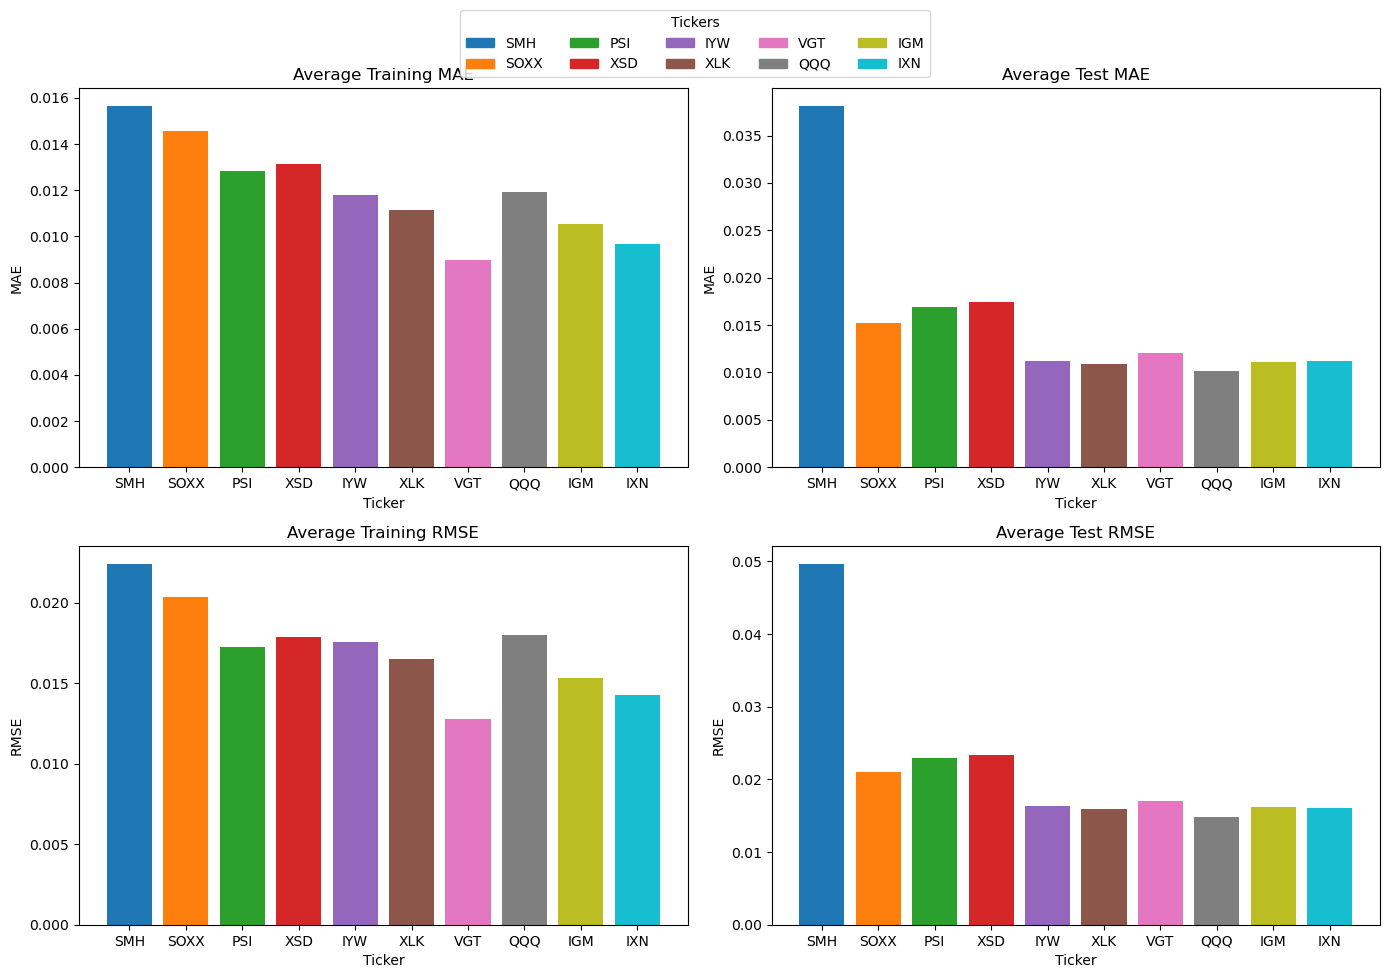

In [14]:
def plot_model_metrics(tickers, results):
    
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))

        computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
    # (Optional) Print some global averages if you want
    print("Overall mean Training MAE:", mean(avg_training_mae))
    print("Overall mean Test MAE:", mean(avg_test_mae))
    print("Overall mean Training RMSE:", mean(avg_training_rmse))
    print("Overall mean Test RMSE:", mean(avg_test_rmse))

    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds" )
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds", )
    # --- 2. Define a color palette for each ticker (must match the number of tickers) ---
    # Example: 10 distinct colors
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    # If you have more than 10 tickers, you need more colors or a different approach.

    # --- 3. Set up a 2×2 subplot grid ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    # Adjust spacing to make room at the top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))  # Use up to 5 columns or fewer if <5 tickers
    )

    plt.show()
plot_model_metrics(tickers, results)

In [15]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
            #print(risk_metrics_results)
    return risk_metrics_results


In [16]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

"""def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores"""

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{month}m'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{month}m'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{month}m'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores

In [17]:
#risk_metrics_results2 = compute_risk_metrics(results2)
#compute_composite_scores(results2, risk_metrics_results2, 0.1)

In [18]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [19]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentages, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'aggregated_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, risk_percentages, smoothing=False):
    all_scores = portfolio(results, risk_percentages, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [20]:

portfolios, final_value = portfolio_optimization(results, risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: -1.7226761392041419, 0.04: -1.6983137202811203, 0.1: -1.6495888824350775, 0.2: -1.5683808193583388}, 'composite_scores_2m': {0.01: -1.6150020654896178, 0.04: -1.600009306511173, 0.1: -1.5700237885542834, 0.2: -1.5200479252928008}, 'composite_scores_3m': {0.01: -1.9753803221596962, 0.04: -1.960513308916019, 0.1: -1.9307792824286645, 0.2: -1.8812225716164068}, 'composite_scores_4m': {0.01: -2.2924504570199793, 0.04: -2.276755640516367, 0.1: -2.2453660075091433, 0.2: -2.193049952497103}, 'composite_scores_5m': {0.01: -2.5402392719285256, 0.04: -2.5255584905968416, 0.1: -2.4961969279334744, 0.2: -2.447260990161195}, 'composite_scores_6m': {0.01: -2.7183079842219477, 0.04: -2.704843744572388, 0.1: -2.6779152652732683, 0.2: -2.6330344664414027}, 'composite_scores_7m': {0.01: -2.7968334400309014, 0.04: -2.783530806456931, 0.1: -2.7569255393089898, 0.2: -2.7125834273957543}, 'composite_scores_8m': {0.01: -2.8188283790557445, 0.04: -2.8057205054764256, 0.1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Buy IXN: 752.15 shares at 66.31.
Buy IYW: 417.29 shares at 119.52.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['IXN', 'IYW']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IXN', 'IYW']
Updated ticker shares after 2024-02-01 to 2024-02-29: {'IXN': 752.1490248273462, 'IYW': 417.29418842728313}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IXN', 'IYW']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IXN', 'IGM']
Sell IYW: 417.29 shares at 135.41. Total value: 56364.54
Buy IGM: 653.48 shares at 86.04.
Updated ticker shares after 2024-03-01 to 2024-03-31: {'IXN': 752.1490248273462, 'IGM': 653.4845403922213}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IXN', 'IGM']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'IGM']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'IXN': 752.1490248273462, 'IGM': 653.4845403922213}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'IGM']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IXN', 'IGM']
Updated ticker shares after 2024-05-01 to 2024-05-31: {'IXN': 752.1490248

In [21]:

portfolios, final_value = portfolio_optimization(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: -1.7226761392041419, 0.04: -1.6983137202811203, 0.1: -1.6495888824350775, 0.2: -1.5683808193583388}, 'composite_scores_2m': {0.01: -1.6150020654896178, 0.04: -1.600009306511173, 0.1: -1.5700237885542834, 0.2: -1.5200479252928008}, 'composite_scores_3m': {0.01: -1.9753803221596962, 0.04: -1.960513308916019, 0.1: -1.9307792824286645, 0.2: -1.8812225716164068}, 'composite_scores_4m': {0.01: -2.2924504570199793, 0.04: -2.276755640516367, 0.1: -2.2453660075091433, 0.2: -2.193049952497103}, 'composite_scores_5m': {0.01: -2.5402392719285256, 0.04: -2.5255584905968416, 0.1: -2.4961969279334744, 0.2: -2.447260990161195}, 'composite_scores_6m': {0.01: -2.7183079842219477, 0.04: -2.704843744572388, 0.1: -2.6779152652732683, 0.2: -2.6330344664414027}, 'composite_scores_7m': {0.01: -2.7968334400309014, 0.04: -2.783530806456931, 0.1: -2.7569255393089898, 0.2: -2.7125834273957543}, 'composite_scores_8m': {0.01: -2.8188283790557445, 0.04: -2.8057205054764256, 0.1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Buy IXN: 752.15 shares at 66.31.
Buy IYW: 417.29 shares at 119.52.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['IXN', 'IYW']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IXN', 'QQQ']
Sell IYW: 417.29 shares at 127.88. Total value: 53230.17
Buy QQQ: 125.86 shares at 421.88.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'IXN': 752.1490248273462, 'QQQ': 125.85828832708121}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IXN', 'QQQ']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IXN', 'QQQ']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'IXN': 752.1490248273462, 'QQQ': 125.85828832708121}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IXN', 'QQQ']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'QQQ']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'IXN': 752.1490248273462, 'QQQ': 125.85828832708121}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'QQQ']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IXN', 'VGT']
Sell QQQ: 125.86 shares at 421.52. Total value: 52919.15
Buy VGT: 107.

In [22]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{week}w'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{week}w'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{week}w'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores


In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentages, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'aggregated_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentages, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentages, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [25]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: -2.3968515486373287, 0.04: -2.3748579986205165, 0.1: -2.330870898586892, 0.2: -2.2575590651975177}, 'composite_scores_2w': {0.01: -1.912441683930559, 0.04: -1.8887166773434443, 0.1: -1.8412666641692146, 0.2: -1.7621833088788323}, 'composite_scores_3w': {0.01: -1.8945415685117082, 0.04: -1.8802480369793977, 0.1: -1.8516609739147767, 0.2: -1.8040158688070749}, 'composite_scores_4w': {0.01: -1.3898424235357303, 0.04: -1.3763089499823429, 0.1: -1.349242002875569, 0.2: -1.3041304243642786}, 'composite_scores_5w': {0.01: -3.2287488073047963, 0.04: -3.215861367141572, 0.1: -3.190086486815123, 0.2: -3.1471283529377074}, 'composite_scores_6w': {0.01: -3.78624793947504, 0.04: -3.7757058444967906, 0.1: -3.754621654540291, 0.2: -3.719481337946125}, 'composite_scores_7w': {0.01: -3.1921409745775877, 0.04: -3.180862097991516, 0.1: -3.1583043448193737, 0.2: -3.1207080895324695}, 'composite_scores_8w': {0.01: -2.9862932221041794, 0.04: -2.973734021038949, 0.1: -2

Buy IGM: 685.80 shares at 72.72.
Buy VGT: 105.83 shares at 471.29.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IGM', 'VGT']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'VGT']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IGM': 685.8026957229545, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'VGT']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'VGT']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IGM': 685.8026957229545, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'VGT']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'VGT']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'IGM': 685.8026957229545, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'VGT']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IGM', 'VGT']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'IGM': 685.8026957229545, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IGM', 'VGT

Final Portfolio Value: 130714.33


In [26]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: -2.3968515486373287, 0.04: -2.3748579986205165, 0.1: -2.330870898586892, 0.2: -2.2575590651975177}, 'composite_scores_2w': {0.01: -1.912441683930559, 0.04: -1.8887166773434443, 0.1: -1.8412666641692146, 0.2: -1.7621833088788323}, 'composite_scores_3w': {0.01: -1.8945415685117082, 0.04: -1.8802480369793977, 0.1: -1.8516609739147767, 0.2: -1.8040158688070749}, 'composite_scores_4w': {0.01: -1.3898424235357303, 0.04: -1.3763089499823429, 0.1: -1.349242002875569, 0.2: -1.3041304243642786}, 'composite_scores_5w': {0.01: -3.2287488073047963, 0.04: -3.215861367141572, 0.1: -3.190086486815123, 0.2: -3.1471283529377074}, 'composite_scores_6w': {0.01: -3.78624793947504, 0.04: -3.7757058444967906, 0.1: -3.754621654540291, 0.2: -3.719481337946125}, 'composite_scores_7w': {0.01: -3.1921409745775877, 0.04: -3.180862097991516, 0.1: -3.1583043448193737, 0.2: -3.1207080895324695}, 'composite_scores_8w': {0.01: -2.9862932221041794, 0.04: -2.973734021038949, 0.1: -2

Buy IGM: 685.80 shares at 72.72.
Buy VGT: 105.83 shares at 471.29.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IGM', 'VGT']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'IYW']
Sell VGT: 105.83 shares at 474.06. Total value: 50042.72
Buy IYW: 413.43 shares at 120.74.
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IGM': 685.8026957229545, 'IYW': 413.43061245996074}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'IYW']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'IYW']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IGM': 685.8026957229545, 'IYW': 413.43061245996074}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'IYW']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'VGT']
Sell IYW: 413.43 shares at 128.57. Total value: 53021.89
Buy VGT: 105.16 shares at 502.96.
Updated ticker shares after 2024-01-22 to 2024-01-28: {'IGM': 685.8026957229545, 'VGT': 105.15614781211181}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'VGT']
Top 2 ETFs for 2024-01-29 to 2024-0

Final Portfolio Value: 130182.55
